# PROJETO CLUSTERIZAÇÃO DE ATIVOS FINANCEIROS

## Introdução

Neste projeto tem-se o objetivo de construir um app web através do qual é possível descobrir similaridades de comportantamento de diversos ativos financeiros negociados na Bolsa de Valores, permitindo aos investidores realização de análises comparativas e tomadas de decisão fundamentada em dados.

Para isso, foram coletados do site https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/cotacoes-historicas/ a base histórica dos ativos negociados na Bolsa de Valores, com período abrangente de 04/01/2021 a 02/08/2024. O escopo será limitado aos ativos negociados no mercado à vista.

A fim de analisar o comportamento dos ativos, será utilizado algoritmo K-means Clustering para Séries Temporais, através da biblioteca Tslearn. Para mais informações sobre este algoritmo, pode ser consultado este site: https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html

## Importação das Bibiotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns


## Coleta e Transformação dos Dados

Nesta etapa, consolidaremos as bases históricas de 2021 a 2024, coletadas no site  https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/cotacoes-historicas/, tratando a estrutura dos dados e filtrando a base de ativos negociados no mercado à vista

In [ ]:
# Variáveis para definição das colunas

list_columns = [
"tipo_registro",
"data_pregao",
"cod_bdi",
"cod_negociacao",
"tipo_mercado",
"noma_empresa",
"especificacao_papel",
"prazo_dias_merc_termo",
"moeda_referencia",
"preco_abertura",
"preco_maximo",
"preco_minimo",
"preco_medio",
"preco_ultimo_negocio",
"preco_melhor_oferta_compra",
"preco_melhor_oferta_venda",
"numero_negocios",
"quantidade_papeis_negociados",
"volume_total_negociado",
"preco_exercicio",
"ìndicador_correcao_precos",
"data_vencimento" ,
"fator_cotacao",
"preco_exercicio_pontos",
"codigo_isin",
"num_distribuicao_papel"]

tamanho_campos=[2,8,2,12,3,12,10,3,4,13,13,13,13,13,13,13,5,18,18,13,1,8,7,13,12,3]

# Variável para ajustar valores com vírgula (dividir os valores dessas colunas por 100)

lista_virgula=[
"preco_abertura",
"preco_maximo",
"preco_minimo",
"preco_medio",
"preco_ultimo_negocio",
"preco_melhor_oferta_compra",
"preco_melhor_oferta_venda",
"volume_total_negociado",
"preco_exercicio",
"preco_exercicio_pontos"
]

In [ ]:
# transformando e concatenando os dados coletados

df = pd.DataFrame(columns=list_columns)

for ano in list(range(2024, 2020, -1)):

  path = f'./dados/input/COTAHIST_A{ano}.TXT'

  dados_acoes = pd.read_fwf(path, widths=tamanho_campos, header=0)
  dados_acoes.drop(labels=dados_acoes.shape[0] - 1, inplace=True)
  dados_acoes.columns = list_columns

  dados_acoes[lista_virgula] = dados_acoes[lista_virgula].div(100)

  df = pd.concat([df, dados_acoes])



In [ ]:
# separando o histórico de ativos negociados em mercado à vista

df = df[df.tipo_mercado == 10]

In [ ]:
# criando e tratando colunas referentes à datas de negociação

df['year'] = df['data_pregao'].map(lambda x: str(x)[:4])
df['month'] = df['data_pregao'].map(lambda x: str(x)[4:6])
df['day'] = df['data_pregao'].map(lambda x: str(x)[6:8])
df['data_pregao'] = pd.to_datetime(df2[['year', 'month', 'day']])
df.sort_values(by='data_pregao', inplace=True, ascending=True)

In [ ]:
# salvando o histórico dos ativos consolidado e transformado para utilização posterior

df.to_csv('/content/drive/MyDrive/PROJ_EBAC_SIMANTEC/DADOS_ACOES/h_consolidado.csv', header=True, index=False)

## Modelagem dos Dados




Nesta etapa, continuaremos com a tarefa de transformação e tratamento dos dados, mas, desta vez, com o intuito de fornecer ao algoritmo de clusterização de séries temporais uma base de dados para treinamento e clusterização, focado nas variações diárias dos preços dos ativos

### 3.1 Dataset com preços de abertura diários dos ativos

In [43]:
# importando a base históriza consolidada

df = pd.read_csv('/content/drive/MyDrive/PROJ_EBAC_SIMANTEC/DADOS_ACOES/h_consolidado.csv')

df.sort_values(by='data_pregao', inplace=True, ascending=True)

df.index = df.data_pregao

df.tail()

,tipo_registro,data_pregao,cod_bdi,cod_negociacao,tipo_mercado,noma_empresa,especificacao_papel,prazo_dias_merc_termo,moeda_referencia,preco_abertura,...,preco_exercicio,ìndicador_correcao_precos,data_vencimento,fator_cotacao,preco_exercicio_pontos,codigo_isin,num_distribuicao_papel,year,month,day
data_pregao,,,,,,,,,,,,,,,,,,,,,
2024-08-02,1,2024-08-02,36.0,BDVY39,10,SELECT DIVID,DRE,NaN,R$,74.97,...,0.0,0.0,99991231.0,1.0,0.0,BRBDVYBDR007,115.0,2024,8,2
2024-08-02,1,2024-08-02,36.0,BQUA39,10,MSCIUSQUAL F,DRE,NaN,R$,64.08,...,0.0,0.0,99991231.0,1.0,0.0,BRBQUABDR001,114.0,2024,8,2
2024-08-02,1,2024-08-02,36.0,BQYL39,10,GX NASDAQ100,DRE,NaN,R$,32.21,...,0.0,0.0,99991231.0,1.0,0.0,BRBQYLBDR000,127.0,2024,8,2
2024-08-02,1,2024-08-02,36.0,BIWF39,10,RUSSEL1000GR,DRE,NaN,R$,78.80,...,0.0,0.0,99991231.0,1.0,0.0,BRBIWFBDR003,113.0,2024,8,2
2024-08-02,1,2024-08-02,2.0,RDNI3,10,RNI,ON NM,NaN,R$,3.31,...,0.0,0.0,99991231.0,1.0,0.0,BRRDNIACNOR9,116.0,2024,8,2


In [36]:
# criando dataset com os registros dos preços de abertura diários nas colunas, de cada ativo financeiro

df_model = pd.DataFrame(index=df.cod_negociacao.unique(), columns=df.data_pregao.unique())

lista_ativos = df.cod_negociacao.unique()

for ativo in lista_ativos:

    colunas = df[df.cod_negociacao == ativo].index
    df_model.loc[ativo, colunas] = df[df.cod_negociacao == ativo].preco_abertura.values

In [38]:
# reorganizando a base de preços diários com a criação de multi-index com tipo de ativo e ativo

lista_ativos = df_model.index
lista_tipos = df_model.index.map(lambda x: x[4:])

df_model.index = pd.MultiIndex.from_arrays([lista_tipos, lista_ativos])

df_model.sort_index(inplace=True)

### 3.2 Dataset com variações dos preços diários dos ativos

In [48]:
# subsituindo valor 0 por np.nan para possibilitar a tarefa de divisão seguinte

df_model[df_model == 0] = np.nan

In [49]:
# criando dataset com os registros das variações diárias dos preços de abertura nas colunas, de cada ativo financeiro

df_final = pd.DataFrame(index=df_model.index, columns=df_model.columns[1:])
colunas = df_model.columns

for ativo in df_model.index:

    df_final.loc[ativo, :] = df_model.loc[ativo, colunas[1:]].values / df_model.loc[ativo, colunas[:-1]].values

### 3.3 Análise do Dataset com as variações diárias

É sabido que há ocorrência de alteração da base nos preços dos ativos, podendo causar distorções na interpreção das variações. Daí, é interessente estabelecer patamares máximo e mínimo para essas variações, de forma a não prejudizar a performance do algoritmo de clusterização.

<Axes: >

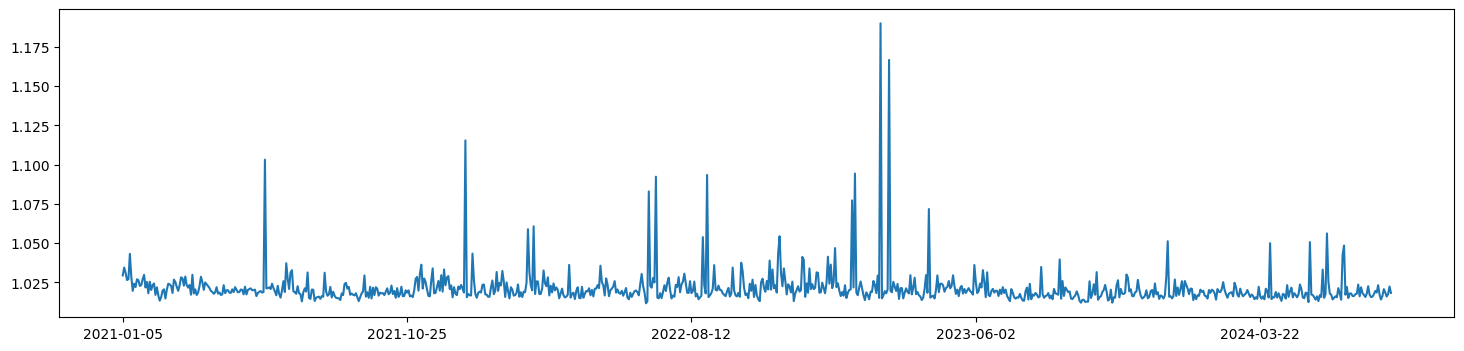

In [85]:
# Médias de variações positivas de preços

df_final[df_final > 1].mean().plot(figsize=(18, 4))

<Axes: >

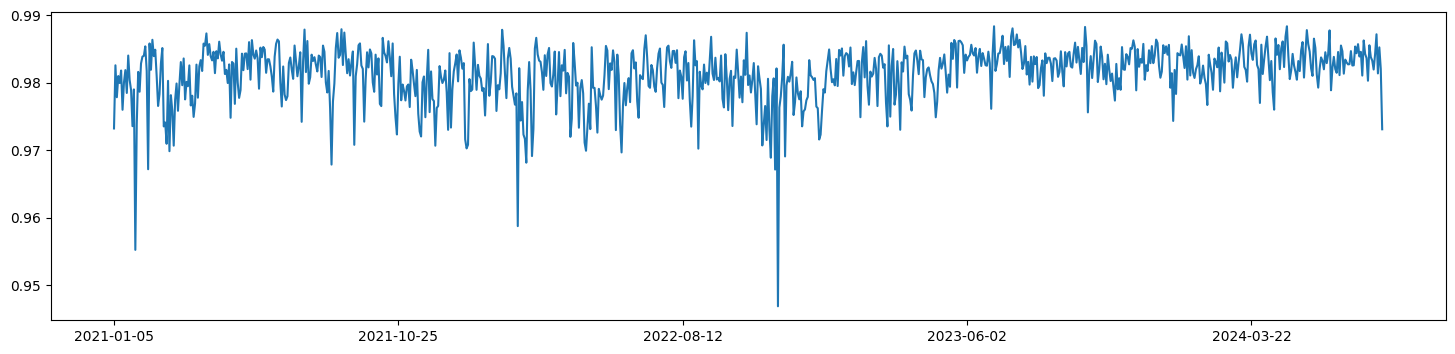

In [86]:
# Médias de variações negativas de preços

df_final[df_final < 1].mean().plot(figsize=(18, 4))

<Axes: >

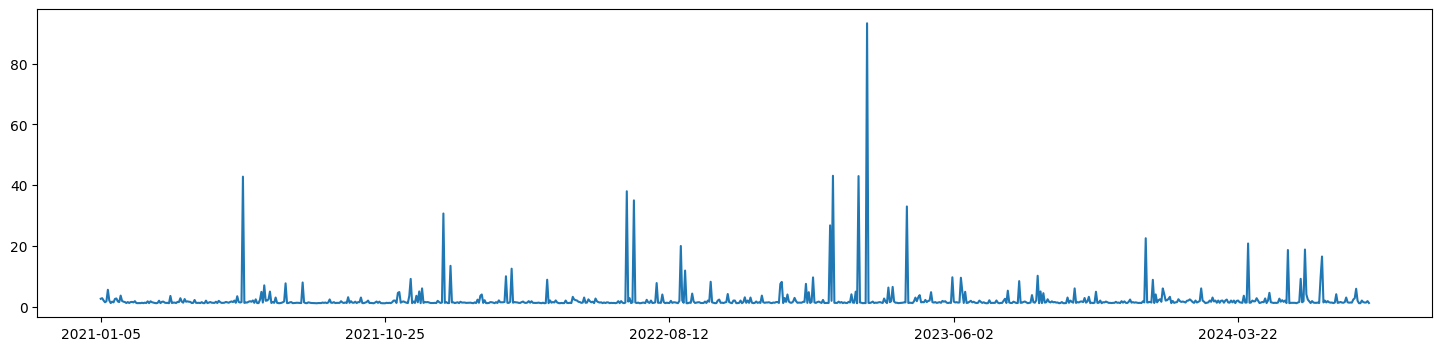

In [81]:
# variações máximas positivas

df_final.max().plot(figsize=(18, 4))

<Axes: >

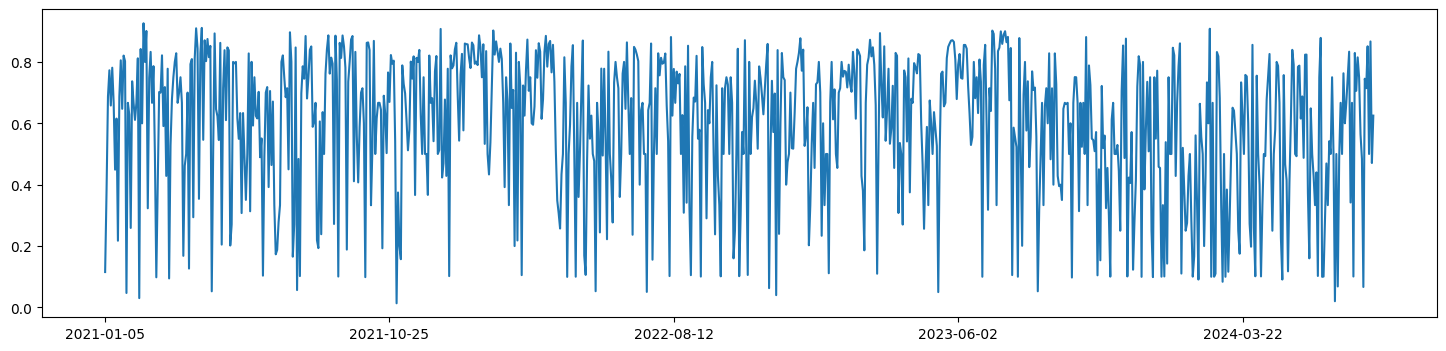

In [82]:
# variações máximas negativas

df_final.min().plot(figsize=(18, 4))

Diante dos gráficos apresentados acima, é razoável estabeler limites superior e inferior para a variações no valores de, respectivamente, 1.3 e 0.76

In [87]:
# limitando as vairações máximas e mínimas

df_final[df_final > 1.3] = 1.3
df_final[df_final < 0.76] = 0.76


## Gravação os Dados Modelados

In [88]:
# gravando os datasets para posterior utilização

df_final.to_csv('./dados/output/df_pre_normal.csv', header=True, index=True)

df_model.to_csv('./dados/output/df_model.csv', header=True, index=True)